<a href="https://colab.research.google.com/github/mrym3/RACLAB/blob/master/Vision%20Transformer%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Vision Transformer (ViT) modelinin semantik segmentasyon (görüntülerin piksellerine etiket atama) görevinde transfer öğrenme yöntemleriyle kullanımı**

Transformer tabanlı bir modelde semantik segmentasyon uygulaması için sidewalk veri seti kullanılmıştır.

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 wh

In [4]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


In [29]:
import json
import torch
import datasets
import requests
import evaluate
import numpy as np
import huggingface_hub
from PIL import Image
import albumentations as A
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Any
from dataclasses import dataclass
from datasets import load_dataset
import matplotlib.patches as mpatches
from huggingface_hub import hf_hub_download
from torch.utils.data import Dataset, DataLoader
from transformers import (
    MaskFormerImageProcessor,
    AutoImageProcessor,
    MaskFormerForInstanceSegmentation,
)

torch.manual_seed(42)

In [33]:
# it seems that we need to login to huggingface to have access to the dataset segments/sidewalk-semantic
huggingface_hub.notebook_login()

# **Veri Seti Yükleme ve Keşfetme**
sidewalk veri Seti 1000 görünütden oluşup 34 kategoriye sahiptir (araçlar, kaldırımlar, inşaat vb.).

In [37]:
hf_dataset_id = "segments/sidewalk-semantic"
dataset = load_dataset(hf_dataset_id)

dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds, test_ds = dataset["train"], dataset["test"]

dataset = train_ds.train_test_split(test_size=0.05)
train_ds, val_ds = dataset["train"], dataset["test"]

In [38]:
filename = "id2label.json"
id2label = json.load(
    open(hf_hub_download(hf_dataset_id, filename, repo_type="dataset"), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
print(id2label)

id2label.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

Bazı örneklerin görselleştirilmesi.

In [50]:
def show_samples(dataset: datasets.Dataset, n: int = 5):
    """
    Displays 'n' samples from the dataset.
    ----
    Args:
      - dataset: The dataset which should contain 'pixel_values' and 'label' in its items.
      - n (int): Number of samples to display.

    """
    if n > len(dataset):
        raise ValueError("n is larger than the dataset size")

    fig, axs = plt.subplots(n, 2, figsize=(10, 5 * n))

    for i in range(n):
        sample = dataset[i]
        image, label = np.array(sample["pixel_values"]), sample["label"]

        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(image)
        axs[i, 1].imshow(label, cmap="nipy_spectral", alpha=0.5)
        axs[i, 1].set_title("Segmentation Map")
        axs[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

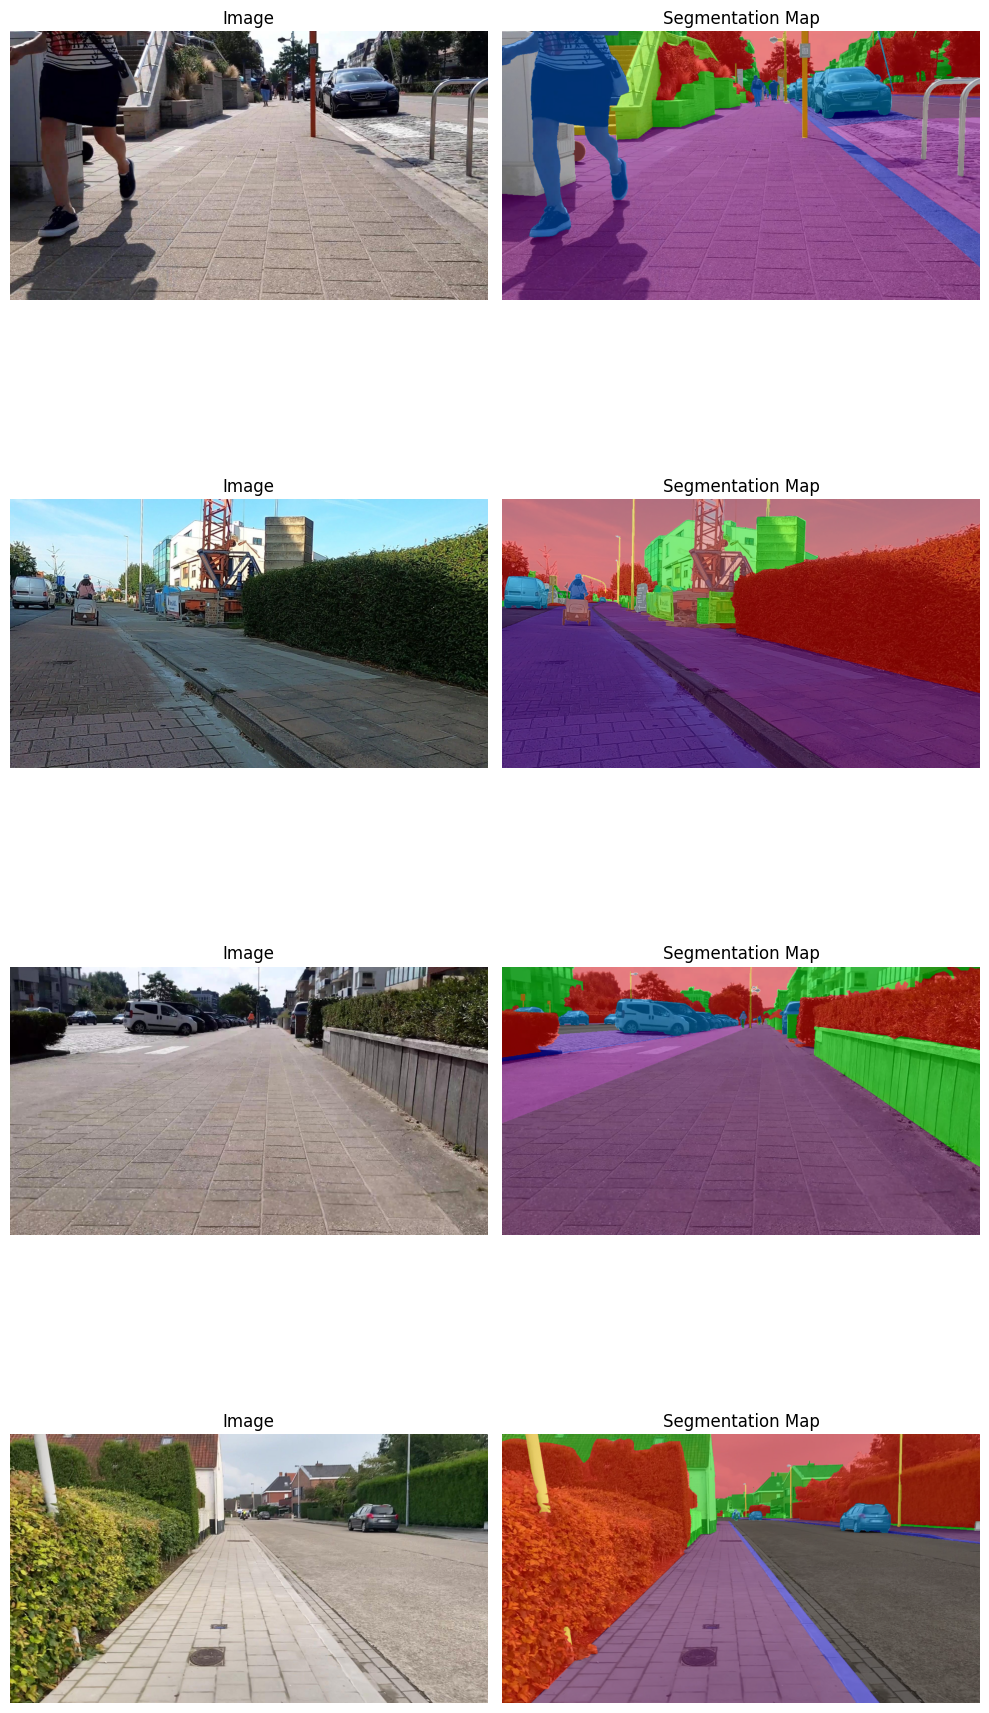

In [46]:
show_samples(train_ds, n=4)

# **Eğitim ve Doğrulama için veri setini hazırlama**
Eğitimin ilerleen bölümlerinde modele girdi olarak verilecek dataların belirli bir formatta olması gerekiyor. Eğitim datalarını dönüştürmek içn bu noktada transformer kütüphanesinde bulunan Preprocessor kullanılabilir.
Modelin farklıdönüşler, ölçeklemeler veya aydınlatma koşullarında daha dayanıklı olmasını sağlamak için, eğitim veri setine veri artırma işlemleri uygulanmalı. Bunun için albumentation kütüphanesi kullanılabilir.
Normalizasyon için ise önceden eğitilmiş veri setinin ortalama (mean) ve standart sapmasını (std) kullanılması yaygındır. Böylece giriş verisinin modelin ilk eğitiminde kullanılan veri ile benzer bir ölçek ve dağılımda olması sağlanır.Bu da modelin performansını ve yakınsamayı (convergence) artırır.

In [57]:
preprocessor = MaskFormerImageProcessor(
    ignore_index=0,
    do_reduce_labels=False,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)
ade_mean = [0.485, 0.456, 0.406]
ade_std = [0.229, 0.224, 0.225]

train_transform = A.Compose(
    [
        A.RandomCrop(width=512, height=512),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=ade_mean, std=ade_std),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(width=512, height=512),
        A.Normalize(mean=ade_mean, std=ade_std),
    ]
)


@dataclass
class SegmentationDataInput:
    original_image: np.ndarray
    transformed_image: np.ndarray
    original_segmentation_map: np.ndarray
    transformed_segmentation_map: np.ndarray


class SemanticSegmentationDataset(Dataset):
    def __init__(self, dataset: datasets.Dataset, transform: Any) -> None:
        """
        Dataset for Semantic Segmentation.
        ----
        Args:
          - dataset: A dataset containing images and segmentation maps.
          - transform: A transformation function to apply to the images and segmentation maps.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        sample = self.dataset[idx]
        original_image = np.array(sample["pixel_values"])
        original_segmentation_map = np.array(sample["label"])

        transformed = self.transform(
            image=original_image, mask=original_segmentation_map
        )
        transformed_image = transformed["image"].transpose(
            2, 0, 1
        )  # Transpose to channel-first format
        transformed_segmentation_map = transformed["mask"]

        return SegmentationDataInput(
            original_image=original_image,
            transformed_image=transformed_image,
            original_segmentation_map=original_segmentation_map,
            transformed_segmentation_map=transformed_segmentation_map,
        )


def collate_fn(batch: SegmentationDataInput) -> dict:
    original_images = [sample.original_image for sample in batch]
    transformed_images = [sample.transformed_image for sample in batch]
    original_segmentation_maps = [sample.original_segmentation_map for sample in batch]
    transformed_segmentation_maps = [
        sample.transformed_segmentation_map for sample in batch
    ]

    preprocessed_batch = preprocessor(
        transformed_images,
        segmentation_maps=transformed_segmentation_maps,
        return_tensors="pt",
    )

    preprocessed_batch["original_images"] = original_images
    preprocessed_batch["original_segmentation_maps"] = original_segmentation_maps

    return preprocessed_batch

In [58]:
train_dataset = SemanticSegmentationDataset(train_ds, transform=train_transform)
val_dataset = SemanticSegmentationDataset(val_ds, transform=train_transform)
test_dataset = SemanticSegmentationDataset(test_ds, transform=test_transform)

# Prepare Dataloaders
train_dataloader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn
)

# Hızlı Doğrulama Kontrolleri

*Uzamsal Boyut Tutarlılığı:* pixel_values, `pixel_mask` ve `mask_labels` değişkenlerinin son iki boyutu eşleşmeli ve (veri artırma işlemlerinden sonra) görüntünün yükseklik ve genişliğine karşılık gelmelidir.

*`mask_labels` için Kanal Boyutları:*
`mask_labels` değişkeninin ilk boyutu (görüntüdeki kategorileri temsil eden kanal sayısı), `class_labels` içindeki değer sayısı ile eşleşmelidir.

In [59]:
sample = next(iter(train_dataloader))
print(
    {
        key: value[0].shape if isinstance(value, list) else value.shape
        for key, value in sample.items()
    }
)

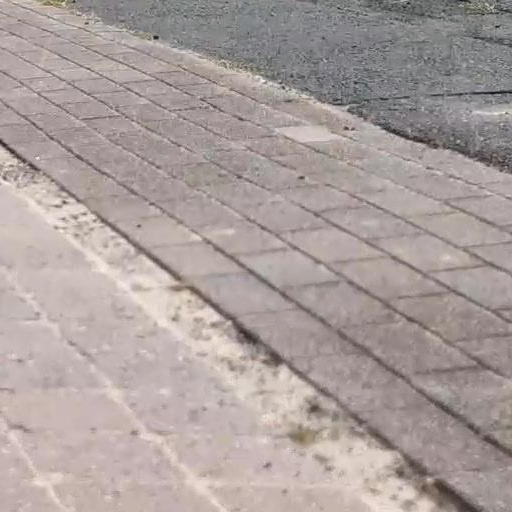

In [60]:
ade_mean = np.array([0.485, 0.456, 0.406])
ade_std = np.array([0.229, 0.224, 0.225])

def denormalize_image(image, mean, std):
    """
    Denormalizes a normalized image.
    ----
    Args:
     - image (numpy.ndarray): The normalized image.
     - mean (list or numpy.ndarray): The mean used for normalization.
     - std (list or numpy.ndarray): The standard deviation used for normalization.

    """
    unnormalized_image = (image * std[:, None, None]) + mean[:, None, None]
    unnormalized_image = (unnormalized_image * 255).numpy().astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return unnormalized_image


denormalized_image = denormalize_image(sample["pixel_values"][0], ade_mean, ade_std)
pil_image = Image.fromarray(denormalized_image)
pil_image

In [61]:
labels = [id2label[label] for label in sample["class_labels"][0].tolist()]
print(labels)

In [62]:
def visualize_mask(sample, labels, label_name):
    print(f"Category: {label_name}")
    idx = labels.index(label_name)

    visual_mask = (sample["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
    return Image.fromarray(visual_mask)

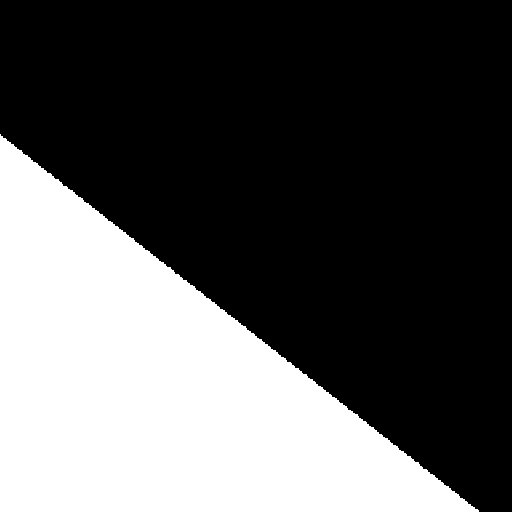

In [63]:
visualize_mask(sample, labels, labels[0])

# **Semantik Segmentasyon için Modeli Yükleme**
**Model Seçimi**
MaskFormer (Cheng ve ark., 2021) modeli, hem semantik segmentasyon (görüntü alanlarını farklı kategorilere ayırma) hem de nesne bazlı segmentasyon (görüntüdeki belirli nesneleri tanımlama) görevlerini çözebilen bir modeldir.
MaskFormer, her piksel için ikili maske ve sınıf etiketi tahmin ederek bu iki görevi birleştirir. Bu yaklaşım, modelin:


*   Semantik segmentasyon yapmasını sağlar (pikselleri belirli sınıflara ayırarak),
*   Nesne bazlı segmentasyonu gerçekleştirmesine olanak tanır (benzersiz maskeler ile her nesneyi ayırt ederek).

Ayrıca panoptik segmentasyonu (panoptic segmentation) da doğal olarak destekler. Çünkü hem semantik etiketlemeyi hem de her piksel için benzersiz bir kimlik atamayı birleştirir.

Modelin Bileşenleri


* Backbone (Omurga): Giriş görüntüsünü işleyerek bir özellik haritası (F) çıkaran, önceden eğitilmiş bir CNN veya Vision Transformer (ViT).
* Pixel Decoder (Piksel Kod Çözücü): Backbone tarafından üretilen özellik haritalarını alarak piksel bazında gömme vektörleri üretir.
* Transformer Decoder (Dönüştürücü Kod Çözücü): Sabit sayıda sorgu (N) ve görüntü özelliklerini (F) kullanarak her bir segment için gömme vektörleri (Q) oluşturur. Bu sorgular (Q), görüntüdeki her bir nesne segmentinin özelliklerini temsil eder.

* Sınıf ve Maske Tahmini:
  * MLP (Çok Katmanlı Algılayıcı), her segmentin K sınıfından birine veya arka plana ait olma olasılığını tahmin eder.
  * İkili maskeler, her segment için ayrı ayrı tahmin edilir.








